In [1]:
from astropy.io import fits
import antropy as ant
import xgboost as xgb
import matplotlib.pyplot as plt
import numpy as np
# import dask.dataframe as dd
import pandas as pd
import os
import numpy as np
import pywt
import matplotlib.pyplot as plt
from keras.src.utils.module_utils import scipy
from scipy.stats import skew, kurtosis
from scipy.signal import find_peaks, periodogram
from scipy.fft import fft
import tensorflow as tf
#import tsfel
from scipy.signal import savgol_filter
from sklearn.model_selection import KFold
from tsfresh import extract_relevant_features
from tsfresh.feature_extraction import EfficientFCParameters
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
def extract_features(time_series, sampling_rate=1.0):
    """
    Extracts a set of temporal and spectral features from a given time series.
    
    Parameters:
    - time_series: np.array, the input time series data
    - sampling_rate: float, the sampling rate of the time series (default is 1.0 Hz)
    
    Returns:
    - features: np.array, an array of extracted feature values
    """
    # Ensure the input is a numpy array
    time_series = np.array(time_series)

    # Temporal Features
    mean_value = np.mean(time_series)
    std_value = np.std(time_series)
    median_flux = np.median(time_series)
    min_flux = np.min(time_series)
    max_flux = np.max(time_series)
    skewness = skew(time_series)
    kurt = kurtosis(time_series)
    peak_to_peak = np.ptp(-time_series)  # Peak-to-peak amplitude
    median_absolute_deviation = np.median(np.abs(time_series - np.median(time_series)))

    # Number of significant peaks
    peaks, _ = find_peaks(time_series)
    num_peaks = len(peaks)
    
    dips, _ = find_peaks(-time_series)
    num_dips = len(dips)
    if len(dips) > 1:
        duration_of_dips = np.mean(np.diff(dips))
    else:
        duration_of_dips = 0

    # Autocorrelation (lag-1)
    if len(time_series) > 1:
        autocorr = np.corrcoef(time_series[:-1], time_series[1:])[0, 1]
    else:
        autocorr = 0

    # Slope of the time series
    slope = (time_series[-1] - time_series[0]) / len(time_series)
    # zero_crossings = np.where(np.diff(np.sign(time_series)))[0]
    # zero_crossing_rate = len(zero_crossings) / len(time_series)
    
    # Spectral Features
    # Compute the Power Spectral Density (PSD) using periodogram
    freqs, power = periodogram(time_series, fs=sampling_rate)

    # Dominant frequency and its power
    if len(freqs) > 1:
        dominant_freq = freqs[np.argmax(power)]
        power_of_dominant_freq = np.max(power)
    else:
        dominant_freq = 0
        power_of_dominant_freq = 0

    # Combine all features into a single array
    features = np.array([
        mean_value, std_value, skewness, kurt, peak_to_peak,
        median_absolute_deviation, num_peaks, autocorr, 
        #slope,
        dominant_freq, 
        #power_of_dominant_freq, 
        num_dips,median_flux,min_flux,max_flux,duration_of_dips
    ])

    return features

In [3]:
def extract_spectral_features(light_curve, sampling_rate=1.0):
    light_curve = np.array(light_curve)
    freqs, power = periodogram(light_curve, fs=sampling_rate)
    
    # Spectrogram Mean Coefficient
    spectrogram_mean = np.mean(power)
    
    # Fundamental Frequency and Max Power Spectrum
    if len(freqs) > 1:
        fundamental_frequency = freqs[np.argmax(power)]
        max_power_spectrum = np.max(power)
    else:
        fundamental_frequency = 0
        max_power_spectrum = 0
    
    # Spectral Centroid
    spectral_centroid = np.sum(freqs * power) / np.sum(power) if np.sum(power) > 0 else 0
    
    # Spectral Entropy
    normalized_power = power / np.sum(power) if np.sum(power) > 0 else power
    spectral_entropy = -np.sum(normalized_power * np.log2(normalized_power + 1e-10))
    
    # Spectral Kurtosis
    spectral_kurtosis = kurtosis(power)
    
    # Spectral Skewness
    spectral_skewness = skew(power)
    
    # Spectral Roll-off (85% energy)
    cumulative_energy = np.cumsum(power)
    spectral_roll_off = freqs[np.where(cumulative_energy >= 0.85 * cumulative_energy[-1])[0][0]] if len(cumulative_energy) > 0 else 0
    
    # Spectral Slope
    if len(freqs) > 1:
        spectral_slope = (power[-1] - power[0]) / (freqs[-1] - freqs[0])
    else:
        spectral_slope = 0
    
    # Wavelet Features
    wavelet = 'db1'  # Daubechies wavelet with one vanishing moment
    coeffs = pywt.wavedec(light_curve, wavelet, level=3)
    
    # Wavelet Energy
    wavelet_energy = np.sum([np.sum(c**2) for c in coeffs])
    
    # Wavelet Entropy
    wavelet_coeffs = np.concatenate(coeffs)
    normalized_wavelet_coeffs = wavelet_coeffs / np.sum(wavelet_coeffs) if np.sum(wavelet_coeffs) > 0 else wavelet_coeffs
    # Filter out zero or negative values before computing the log
    valid_coeffs = normalized_wavelet_coeffs[normalized_wavelet_coeffs > 0]
    wavelet_entropy = -np.sum(valid_coeffs * np.log2(valid_coeffs + 1e-10))
    
    # Combine all features into a single array
    features = np.array([
        spectrogram_mean, fundamental_frequency, max_power_spectrum, #spectral_centroid,
        spectral_entropy, spectral_kurtosis, spectral_skewness, spectral_roll_off,
        #spectral_slope, 
        wavelet_energy, wavelet_entropy
    ])
    
    return features
def compute_additional_features(light_curve):
    features = []

    # Spectral Flatness
    power_spectrum = np.abs(np.fft.fft(light_curve))**2
    spectral_flatness = np.exp(np.mean(np.log(power_spectrum + 1e-10))) / np.mean(power_spectrum)
    features.append(spectral_flatness)

    # Lagged Autocorrelations
    autocorr_lag_5 = np.corrcoef(light_curve[:-5], light_curve[5:])[0, 1]
    features.append(autocorr_lag_5)

    # Zero-Crossing Rate
    zero_crossings = np.where(np.diff(np.sign(light_curve)))[0]
    zero_crossing_rate = len(zero_crossings) / len(light_curve)
    features.append(zero_crossing_rate)

    # Approximate Entropy (using a simplified method)
    def approximate_entropy(U, m, r):
        N = len(U)
        def _phi(m):
            x = np.array([U[i : i + m] for i in range(N - m + 1)])
            C = np.sum(np.max(np.abs(x[:, None] - x[None, :]), axis=2) <= r, axis=0) / (N - m + 1)
            return np.sum(np.log(C)) / (N - m + 1)
        return abs(_phi(m + 1) - _phi(m))

    approx_entropy = ant.app_entropy(light_curve, order=2, metric='chebyshev')
    #approx_entropy = approximate_entropy(light_curve, m=2, r=0.2 * np.std(light_curve))
    features.append(approx_entropy)

    return np.array(features)

In [4]:
def get_dip_depths(light_curve,time, prominence=1, distance=5 ):
    baseline_flux = np.median(light_curve)  
    inverted_light_curve = baseline_flux - light_curve
    #inverted_light_curve = -light_curve
    dips, properties = find_peaks(inverted_light_curve, prominence=prominence)
    dip_depths = baseline_flux - light_curve[dips]
    dip_durations = []
    
    negative_count = 0
    for dip in dips:
        # Find the start of the dip
        start_index = dip
        while start_index > 0 and light_curve[start_index] < baseline_flux:
            start_index -= 1
        end_index = dip
        while end_index < len(light_curve) - 1 and light_curve[end_index] < baseline_flux:
            end_index += 1
        duration = time[end_index] - time[start_index]
        if duration < 0:
            negative_count += 1
            duration = 1e-15
        #print(time[start_index], time[end_index], duration)
        dip_durations.append(duration)

    return dip_depths, dips, dip_durations, True if negative_count == len(dips) else False
    
def dip_related_features(light_curve, time_array, sampling_interval):
    dip_depths, dips, dip_durations, all_neg = get_dip_depths(light_curve, time_array)
    num_dips = len(dips)
    avg_dip_depth = 0 if all_neg else np.mean(dip_depths)
    max_dip_depth = 0 if all_neg else np.max(dip_depths)
    variance_dip_depth = 1e10 if all_neg else np.var(dip_depths)
    avg_dip_duration = np.mean(dip_durations)
    total_dip_duration = np.sum(dip_durations)
    dip_distances = np.diff(dips)
    dip_distances_in_time = dip_distances * sampling_interval
    avg_distance = np.mean(dip_distances_in_time)
    min_distance = np.min(dip_distances_in_time)
    max_distance = np.max(dip_distances_in_time)
    std_distance = np.std(dip_distances_in_time)
    median_dist = np.median(dip_distances_in_time)
    #dip_frequency = len(num_dips) / total_time
    #dip_depth_duration_ratio = np.mean(dip_depths / dip_durations)
    #dip_symmetry = np.mean(np.abs(rise_times - fall_times))
    #avg_time_between_dips = np.mean(np.diff(dip_times))
    skewness_dip_depth = scipy.stats.skew(dip_depths)
    kurtosis_dip_depth = kurtosis(dip_depths)
    return [num_dips, avg_dip_depth, max_dip_depth, variance_dip_depth, avg_dip_duration, total_dip_duration,skewness_dip_depth, kurtosis_dip_depth, avg_distance, min_distance, max_distance, std_distance,median_dist]
    
    

In [5]:
import sys
index = 0
positive_folder = "./data/positive/"
negative_folder = "./data/negative/"
flux_array = []
time_array = []
id_list = []
labels = []
count = 0
# label_obj = {}
start_of_0_ind = 0
extracted_features_list = []
def load_fits_data(folder, label):
    for filename in os.listdir(folder):
        if filename.endswith('.fits'):
            with fits.open(os.path.join(folder, filename)) as hdul:
                try:
                    global index
                    data = hdul[1].data
                    header = hdul[1].header
                    time = data['TIME']
                    flux = data['PDCSAP_FLUX']
                    #print("flux", flux.shape)
                    obsmode = header.get('OBSMODE')
                    timedel = header.get('TIMEDEL') * 86400
                    sampling_rate = 1/timedel
                    #print(obsmode, timedel, sampling_rate)

                    valid_indices = ~np.isnan(time) & ~np.isnan(flux)
                    time = time[valid_indices]
                    flux = flux[valid_indices]
                    # mean = np.mean(flux)
                    # std = np.std(flux)
                    # new_flux = (flux - mean) / std
                    smoothed_flux = savgol_filter(flux, window_length=201, polyorder=6)
                    #detrended_flux = flux - smoothed_flux
                    
                    #Needed for tsfresh
                    # id_arr = np.array([index for i in range(flux.shape[0])])
                    # time_array.extend(time)
                    # flux_array.extend(flux)
                    # id_list.extend(id_arr)
                    
                    # label_obj[index] = label
                    
                    # basic_features = extract_features(smoothed_flux, sampling_rate)
                    spectral_features = extract_spectral_features(smoothed_flux, sampling_rate)
                    # # #detrend_features = extract_features(detrended_flux, sampling_rate)
                    additional_features =compute_additional_features(smoothed_flux)
                    dip_features = dip_related_features(smoothed_flux, time,timedel)
                    #print(basic_features)
                    X = np.concatenate((
                        #basic_features, 
                        spectral_features,
                        additional_features,dip_features))
                    #X = np.array(dip_features)
                    extracted_features_list.append(X)
                    # print(len(basic_features), len(spectral_features), len(additional_features), len(dip_features))
                    #print(dip_features)
                    #n = len(time)
                    
                    #Needed for tsfresh
                    # flux_array.extend(smoothed_flux)
                    # time_array.extend(time)
                    # id_list.extend([index] * n)
                    # labels.extend([label] * n)
                    index += 1
                    labels.append(label)
                    #print(X.shape)
                except ValueError as e:
                    print("ValueError error for filename", e)
                except AttributeError as e:
                    print("AttributeError error for filename", filename, e)
                except TypeError as e:
                    print("TypeError error for filename", filename, e)
                except NameError as e:
                    print("NameError error for filename", filename, e)
                except Exception as ex:
                    print("got error for filename", filename, index)
                    print("Unexpected error:", sys.exc_info()[0])

In [6]:
#index=1
load_fits_data(positive_folder, label=1)
#index =1
load_fits_data(negative_folder, label=0)
print("start_of_0_ind",start_of_0_ind)



#

TypeError error for filename kplr002713049-2012179063303_llc.fits buffer is too small for requested array


TypeError error for filename kplr003544595-2010355172524_llc.fits buffer is too small for requested array


/opt/anaconda3/envs/tensor_py9/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/tensor_py9/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


ValueError error for filename zero-size array to reduction operation minimum which has no identity


/opt/anaconda3/envs/tensor_py9/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/tensor_py9/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


ValueError error for filename zero-size array to reduction operation minimum which has no identity


/opt/anaconda3/envs/tensor_py9/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/tensor_py9/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


ValueError error for filename zero-size array to reduction operation minimum which has no identity


/opt/anaconda3/envs/tensor_py9/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/tensor_py9/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


ValueError error for filename zero-size array to reduction operation minimum which has no identity


TypeError error for filename kplr002850321-2013098041711_llc.fits buffer is too small for requested array


TypeError error for filename kplr002437209-2011116030358_slc.fits buffer is too small for requested array
start_of_0_ind 0


In [7]:
## TSFRESH BLOCK
# df = pd.DataFrame({
#     'time': time_array,a

#     'id': id_list,
#     'flux': flux_array
# })
# print(df.dtypes)
# print(df.isnull().sum())
# print(len(labels), len(id_list), len(flux_array), len(time_array))
# label_series = pd.Series(np.array(labels))
# print(max(id_list))
# missing_ids = set(df['id'].unique()) - set(label_series.index)
# print("Missing IDs:", missing_ids)
from tsfresh.utilities.distribution import MultiprocessingDistributor
# Distributor = MultiprocessingDistributor(n_workers=4,
#                                          disable_progressbar=False,
#                                          progressbar_title="Feature Extraction")
# extracted_features = extract_relevant_features(
#     df,
#     y=label_series,
#     column_id="id",
#     column_sort="time",
#     column_value="flux",
#     #distributor=Distributor,
#     #n_jobs=2  # Use all available cores
# )
# from tsfresh.utilities.distribution import MultiprocessingDistributor
# Distributor = MultiprocessingDistributor(n_workers=4,
#                                          disable_progressbar=False,
#                                          progressbar_title="Feature Extraction")
# sample_df = df.sample(n=500, random_state=42)
# sample_ids = []
# sample_ids.extend(range(0,50))
# sample_ids.extend(range(60242829,60242828+51))#sample_df['id'].unique()  # Get unique ids from the sample
# print(sample_ids)
#filtered_df = df[df['id'].isin(sample_ids)]  # Filter DataFrame to only include these ids
#labels_series_sample = label_series[label_series.index.isin(sample_ids)]
#print("labels_series_sample",labels_series_sample)
# extracted_features = extract_relevant_features(
#     df,
#     y=label_series,
#     column_id="id",
#     column_sort="time",
#     column_value="flux",
#     #distributor=Distributor,
#     n_jobs=-1  # Use all available cores
# )
# print(extracted_features.shape)
#extracted_features.to_csv('extracted_features.csv')
# print(extracted_features.shape)

In [8]:
print(len(extracted_features_list), len(labels), index)
# Feature 25: 0.1067
# Feature 27: 0.0736
# Feature 10: 0.0657
# Feature 24: 0.0586
# Feature 12: 0.0564
# Feature 14: 0.0543
# Feature 7: 0.0536
# Feature 28: 0.0477
# Feature 32: 0.0444
# Feature 9: 0.0399
# Feature 16: 0.0370
# Feature 1: 0.0367
# Feature 11: 0.0326
# Feature 15: 0.0308
# Feature 8: 0.0307
# Feature 5: 0.0292
# Feature 13: 0.0284
# Feature 22: 0.0274
# Feature 23: 0.0200
# Feature 3: 0.0189
# Feature 21: 0.0181
# Feature 29: 0.0167
# Feature 6: 0.0125
extracted_features_list = np.array(extracted_features_list)
# indexes = [25,27,10,24,12,14,7,28,32,9,16,11,1,15,8,5,13,22,23,3,21,29,6]
# indexes.sort()
# print("len", len(indexes), extracted_features_list.shape)
# extracted_features_list = extracted_features_list[:,indexes]
scaler = StandardScaler()
extracted_features_list = scaler.fit_transform(extracted_features_list)
#print("extracted_features_list normaised", extracted_features_list)
labels = np.array(labels)
x, x_test, y, y_test = train_test_split(extracted_features_list, labels, test_size=0.2)
print(extracted_features_list.shape, x.shape, x_test.shape, y.shape, y_test.shape)

9994 9994 9994
(9994, 26) (7995, 26) (1999, 26) (7995,) (1999,)


In [9]:
def get_classifier():
    #model = RandomForestClassifier(n_estimators=100, random_state=42)
    #model = LogisticRegression(random_state=42)
    # model = SVC(kernel='linear', random_state=42)
    # model = GradientBoostingClassifier(n_estimators=700, random_state=2, learning_rate=0.01, max_depth=3, subsample=0.8, min_samples_leaf=2, min_samples_split=2)
    model = xgb.XGBClassifier(
        n_estimators=1500,  # Number of trees (increase with lower learning rate)
        learning_rate=0.001,  # Lower learning rate for better generalization
        max_depth=10,  # Control tree depth (reduce to prevent overfitting)
        subsample=0.9,  # Use 80% of training samples for each tree
        colsample_bytree=0.9,  # Use 80% of features for each tree
        min_child_weight=50,  # Minimum sum of instance weight (controls complexity)
        gamma=0.005,  # Minimum loss reduction (regularization)
        #objective='binary:logistic',  # Suitable for binary classification
        eval_metric='auc',  # Metric to evaluate (logarithmic loss)
        use_label_encoder=False,  # Disable label encoding for newer versions
        random_state=42,  # Set a random state for reproducibility,
        tree_method='exact'
        #early_stopping_rounds=200
    )
    return model

In [10]:
# def get_nn_model():

In [11]:
def run_model(x, y, model):
    kfold = KFold(n_splits=2, shuffle=True)
    accuracy_list = []
    precision_list = []
    recall_list = []
    train_accuracy_list = []
    for train_index, validation_index in kfold.split(x):
        X_train, X_val = x[train_index], x[validation_index]
        y_train, y_val = y[train_index], y[validation_index]
        eval_set = [(X_val, y_val)]
        #model.fit(X_train, y_train)
        
        #fit for xgboost:
        model.fit(X_train, y_train, eval_set=eval_set, verbose=True)
        y_train_pred_prob = model.predict_proba(X_train)[:,1]
        y_val_pred_prob = model.predict_proba(X_val)[:,1]
        y_train_pred = (y_train_pred_prob > 0.48).astype(int)
        y_val_pred = (y_val_pred_prob > 0.48).astype(int)
        accuracy_list.append(accuracy_score(y_val, y_val_pred))
        train_accuracy_list.append(accuracy_score(y_train, y_train_pred))
        precision_list.append(precision_score(y_val, y_val_pred))
        recall_list.append(recall_score(y_val, y_val_pred))
    return accuracy_list, precision_list, recall_list,train_accuracy_list


In [12]:
def predict(model, x, y):
    y_pred_prob = model.predict_proba(x)[:,1]
    y_pred = (y_pred_prob > 0.48).astype(int)
    test_accuracy = accuracy_score(y, y_pred)
    test_precision = precision_score(y, y_pred)
    test_recall = recall_score(y, y_pred)
    return test_accuracy, test_precision, test_recall

In [13]:
model = get_classifier()
accuracy_list, precision_list, recall_list, train_accuracy_list = run_model(x, y, model)
feature_importances = model.feature_importances_
## for importance of xgbost
# xgb.plot_importance(model, importance_type="weight")
# plt.show()

# Sort and display feature importances
sorted_indices = np.argsort(feature_importances)[::-1]
print("Feature Importances:")
for idx in sorted_indices:
    print(f"Feature {idx + 1}: {feature_importances[idx]:.4f}")
test_accuracy, test_precision, test_recall = predict(model, x_test, y_test)

[0]	validation_0-auc:0.75433
[1]	validation_0-auc:0.76134
[2]	validation_0-auc:0.76339
[3]	validation_0-auc:0.76986
[4]	validation_0-auc:0.77253
[5]	validation_0-auc:0.76930
[6]	validation_0-auc:0.77144
[7]	validation_0-auc:0.77233
[8]	validation_0-auc:0.77390
[9]	validation_0-auc:0.77379
[10]	validation_0-auc:0.77377
[11]	validation_0-auc:0.77397
[12]	validation_0-auc:0.77341
[13]	validation_0-auc:0.77315


/opt/anaconda3/envs/tensor_py9/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [23:05:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[14]	validation_0-auc:0.77369
[15]	validation_0-auc:0.77355
[16]	validation_0-auc:0.77338
[17]	validation_0-auc:0.77349
[18]	validation_0-auc:0.77327
[19]	validation_0-auc:0.77369
[20]	validation_0-auc:0.77369
[21]	validation_0-auc:0.77411
[22]	validation_0-auc:0.77421
[23]	validation_0-auc:0.77411
[24]	validation_0-auc:0.77388
[25]	validation_0-auc:0.77376
[26]	validation_0-auc:0.77398
[27]	validation_0-auc:0.77387
[28]	validation_0-auc:0.77404
[29]	validation_0-auc:0.77410
[30]	validation_0-auc:0.77440
[31]	validation_0-auc:0.77443
[32]	validation_0-auc:0.77500
[33]	validation_0-auc:0.77484
[34]	validation_0-auc:0.77535
[35]	validation_0-auc:0.77555
[36]	validation_0-auc:0.77533
[37]	validation_0-auc:0.77522
[38]	validation_0-auc:0.77499
[39]	validation_0-auc:0.77459
[40]	validation_0-auc:0.77435
[41]	validation_0-auc:0.77455
[42]	validation_0-auc:0.77484
[43]	validation_0-auc:0.77450
[44]	validation_0-auc:0.77502
[45]	validation_0-auc:0.77483
[46]	validation_0-auc:0.77492
[47]	valid

/opt/anaconda3/envs/tensor_py9/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [23:05:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[26]	validation_0-auc:0.77180
[27]	validation_0-auc:0.77140
[28]	validation_0-auc:0.77141
[29]	validation_0-auc:0.77082
[30]	validation_0-auc:0.77126
[31]	validation_0-auc:0.77177
[32]	validation_0-auc:0.77173
[33]	validation_0-auc:0.77206
[34]	validation_0-auc:0.77163
[35]	validation_0-auc:0.77175
[36]	validation_0-auc:0.77130
[37]	validation_0-auc:0.77121
[38]	validation_0-auc:0.77156
[39]	validation_0-auc:0.77117
[40]	validation_0-auc:0.77143
[41]	validation_0-auc:0.77170
[42]	validation_0-auc:0.77200
[43]	validation_0-auc:0.77212
[44]	validation_0-auc:0.77181
[45]	validation_0-auc:0.77182
[46]	validation_0-auc:0.77214
[47]	validation_0-auc:0.77212
[48]	validation_0-auc:0.77220
[49]	validation_0-auc:0.77252
[50]	validation_0-auc:0.77222
[51]	validation_0-auc:0.77198
[52]	validation_0-auc:0.77181
[53]	validation_0-auc:0.77188
[54]	validation_0-auc:0.77155
[55]	validation_0-auc:0.77142
[56]	validation_0-auc:0.77144
[57]	validation_0-auc:0.77163
[58]	validation_0-auc:0.77163
[59]	valid

0.6843421710855427 0.6865261228230981 0.7215799614643545


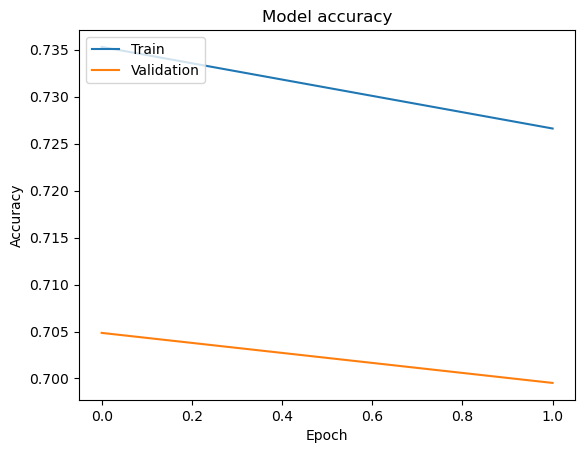

In [14]:
print(test_accuracy, test_precision, test_recall)
plt.plot(train_accuracy_list)
plt.plot(accuracy_list)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [15]:

print(test_accuracy, test_precision, test_recall)

0.6843421710855427 0.6865261228230981 0.7215799614643545


In [16]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
base_model = DecisionTreeClassifier()

# Create BaggingClassifier
bagging_model = BaggingClassifier(base_model, n_estimators=500, random_state=42)
bagging_model.fit(x, y)

# Predict and evaluate
y_pred = bagging_model.predict(x_test)
print("Bagging Accuracy:", accuracy_score(y_test, y_pred))

Bagging Accuracy: 0.7618809404702351


In [20]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Example data (replace with your feature array `X` and labels `y`)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the MLP classifier
model = MLPClassifier(hidden_layer_sizes=(128, 128), activation='relu', solver='adam', max_iter=1000)

# Train the model
model.fit(x, y)

# Evaluate the model
y_pred = model.predict(x_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.6633316658329165
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.59      0.63       961
           1       0.66      0.74      0.69      1038

    accuracy                           0.66      1999
   macro avg       0.66      0.66      0.66      1999
weighted avg       0.66      0.66      0.66      1999

